<a href="https://colab.research.google.com/github/Koushikl0l/StockHound/blob/main/Demo3_StockHound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load Libraries for Data Processing
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import os
# ML Libraries
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.layers import  GRU, Bidirectional, Attention, Concatenate, Input, Flatten,LayerNormalization
from tensorflow.keras.regularizers import l2,l1

#For plotting
import matplotlib.pyplot as plt
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
#For any sort of unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
dataset_path = '/content/drive/MyDrive/NEPSE/input_data.csv'
output_dir_path = '/content/drive/MyDrive/NEPSE/'

def load_and_prepare_data(file_path, output_dir_path, date_col='Date'):

    # Read the data from the CSV file
    data = pd.read_csv(file_path, index_col=0)
    # Convert the date column to datetime and extract the date part
    data[date_col] = pd.to_datetime(data[date_col]).dt.date
    # Set the date column as the index
    data.set_index(date_col, inplace=True)

    return data

data = load_and_prepare_data(dataset_path,output_dir_path)
data.head()


,Open,High,Low,Close,Volume,MACD,RSI,ATR,MFI,CPI,USDX,IR,TB,EFFR,RMT,Score
Date,,,,,,,,,,,,,,,,
2016-07-17,1718.15,1749.96,1715.14,1745.74,2272045,-37.509420,74.940143,23.122890,70.196510,112.9,107.519,8.6,0.44,0.82,51.94,0.20955
2016-07-18,1745.74,1786.68,1745.74,1786.59,2870497,-41.071885,82.962838,24.395540,67.197424,112.9,107.519,8.6,0.44,0.82,51.94,0.21927
2016-07-19,1786.59,1813.42,1785.33,1800.47,2902127,-44.502170,84.862752,24.659430,65.486818,112.9,107.519,8.6,0.44,0.82,51.94,-0.02642
2016-07-20,1800.47,1813.44,1782.57,1786.84,3474801,-45.595275,75.342839,25.103042,55.037084,112.9,107.519,8.6,0.44,0.82,51.94,0.15107
2016-07-21,1786.84,1804.75,1779.71,1798.83,3154492,-46.888559,77.863404,25.098539,67.326060,112.9,107.519,8.6,0.44,0.82,51.94,0.12900


### Feature Engineering

In [3]:
def look_back_window(df, target_col, time_step=1):
    """
    Creates a time series dataset using a look-back window approach.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the features and target.
    target_col (str): The column name of the target variable.
    time_step (int): The number of time steps to look back for the feature window. Defaults to 1.

    Returns:
    tuple: A tuple containing two numpy arrays:
        - X_data: Array of feature windows of shape (num_samples, time_step, num_features)
        - y_data: Array of target values corresponding to each feature window.
    """
    # Extract target and features
    y = df[target_col].values
    X_df = df.drop(columns=[target_col])
    X_array = X_df.values

    X_data, y_data = [], []

    # Generate the look-back window for each data point
    for i in range(len(df) - time_step):
        feature_window = X_array[i:(i + time_step), :]
        X_data.append(feature_window)
        y_data.append(y[i + time_step])

    return np.array(X_data), np.array(y_data)

def split_train_val_test(X,y, train_size=0.8, val_test_size=0.10, random_state=42):


    # First split to get 70% training data and 30% remaining data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=random_state)
    # Split the remaining 30% into 50/50 for validation and test (15% each of total data)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test



1. We need to define the MAPE function, ensuring it can be used in TensorFlow's graph computation.
2. We'll handle cases where the actual value (y_i = 0\) to avoid division by zero errors.


$$
MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
\
$$

In [8]:
import tensorflow as tf

def mean_absolute_precision_error(y_true, y_pred):
    # Ensure that neither y_true nor y_pred is None
    if y_true is None:
        raise ValueError("y_true is None")
    if y_pred is None:
        raise ValueError("y_pred is None")

    # Avoid division by zero by adding a small epsilon
    epsilon = tf.keras.backend.epsilon()

    # Ensure both y_true and y_pred are tensors
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)

    # Reshape y_pred to match y_true if necessary
    y_pred = tf.squeeze(y_pred, axis=-1)  # Remove extra dimension if needed

    # Compute absolute percentage error
    abs_diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), epsilon, None))

    # Return mean absolute percentage error
    return tf.reduce_mean(abs_diff) * 100


In [58]:

def mape(y_true, y_pred):
    # Replace None values (or NaN) in y_true with 0
    y_true = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)

    # Compute the absolute percentage error
    abs_diff = tf.abs((y_true - y_pred) / tf.where(y_true != 0, y_true, tf.ones_like(y_true)))

    # Compute the mean, ignore NaN values (if they were present)
    mape_value = tf.reduce_mean(abs_diff) * 100

    return mape_value

def rmsle(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))

def custom_scaled_mape(y_true, y_pred):
    y_true_log = tf.math.log1p(y_true)
    y_pred_log = tf.math.log1p(y_pred)

    # Compute MAPE on the scaled (log) values
    return tf.reduce_mean(tf.abs((y_true_log - y_pred_log) / tf.maximum(y_true_log, 1e-8))) * 100

### Preprocessing

In [5]:
def scale_data(df, feature_range=(0, 1)):

    # Initialize MinMaxScaler with the provided feature range
    scaler = MinMaxScaler(feature_range=feature_range)

    # Fit the scaler to the DataFrame and transform it
    scaled_data = scaler.fit_transform(df)

    # Return the scaled data as a DataFrame with the same column names and index
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

    return scaled_df, scaler

def inverse_scale(scaler,scaled_data):

    # Extract the min and max values
    min_vals = scaler.data_min_[0]
    max_vals = scaler.data_max_[0]

    # Apply inverse transformation for each feature
    original_data = min_vals + scaled_data * (max_vals - min_vals)

    return original_data

# Example Usage:
# scaled_df, scaling_params, scaler = scale_data(df)
# original_df = inverse_scale(scaled_df, scaling_params)


In [62]:
def lstm_model(input_shape):
    """
    Builds an advanced LSTM model for stock price prediction with additional
    normalization, attention mechanism, and regularization for robustness.

    Parameters:
    input_shape (tuple): The shape of the input data (time_steps, num_features).

    Returns:
    keras.models.Model: Compiled advanced LSTM model.
    """
    # Input layer
    inputs = Input(shape=input_shape)
    # Bidirectional LSTM layer with Layer Normalization
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))(inputs)
    x = LayerNormalization()(x)
    #x = Dropout(0.3)(x)
    # Second LSTM layer with L2 regularization
    x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = LayerNormalization()(x)
    #x = Dropout(0.3)(x)
    # GRU layer with regularization
    x = GRU(64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    #x = Dropout(0.3)(x)
    # Attention mechanism: Query and Value are the same (self-attention)
    query = x
    value = x
    attention_output = Attention()([query, value])
    # Concatenate attention output with the previous GRU output
    x = Concatenate()([x, attention_output])
    # GlobalAveragePooling to collapse time steps and make the output compatible for final Dense layers
    x = GlobalAveragePooling1D()(x)
    # Dense layer
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    #x = Dropout(0.2)(x)

    # Output layer
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mae',metrics=[rmsle,
        #mean_absolute_precision_error
        ])

    return model



In [63]:
class StockPricePredictor:
    def __init__(self, dataset_path, output_dir_path, target_col='Close', time_step=3):
        self.dataset_path = dataset_path
        self.output_dir_path = output_dir_path
        self.target_col = target_col
        self.time_step = time_step
        self.scaler = None
        self.model = None
        self.scalings_params = None

    def load_and_prepare_data(self):
        data = pd.read_csv(self.dataset_path, index_col=0)
        data['Date'] = pd.to_datetime(data['Date']).dt.date
        data.set_index('Date', inplace=True)
        return data

    def prepare_data(self, data):
        scaled_data, scaler = scale_data(data)
        self.scaler = scaler

        X, y = look_back_window(scaled_data, self.target_col, self.time_step)

        X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X,y)

        return X_train, y_train, X_val, y_val, X_test, y_test, self.scaler

    def create_model(self, input_shape):
        self.model = lstm_model(input_shape)

    def train_model(self, X_train, y_train, X_val, y_val, epochs=55, batch_size=8):
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(f"{self.output_dir_path}/best_model.keras", save_best_only=True)

        history = self.model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[early_stopping, model_checkpoint])

        return history


    def call(self):
        data = self.load_and_prepare_data()
        X_train, y_train, X_val, y_val, X_test, y_test, scalar= self.prepare_data(data)

        # Reshape for LSTM
        input_shape = (X_train.shape[1], X_train.shape[2])
        self.create_model(input_shape)

        history = self.train_model(X_train, y_train, X_val, y_val)

        # Optionally, return the trained model or other results
        return self.model, history, X_test, y_test, scalar

# Example usage
dataset_path = '/content/drive/MyDrive/NEPSE/input_data.csv'
output_dir_path = '/content/drive/MyDrive/NEPSE/saved_model'
predictor = StockPricePredictor(dataset_path, output_dir_path)
trained_model, history, X_test, y_test, scalar = predictor.call()

Epoch 1/55
105/105 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - loss: 4.6802 - rmsle: 0.2170 - val_loss: 3.5458 - val_rmsle: 0.1791
Epoch 2/55
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.2716 - rmsle: 0.1880 - val_loss: 2.5895 - val_rmsle: 0.1860
Epoch 3/55
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.3968 - rmsle: 0.1860 - val_loss: 1.9529 - val_rmsle: 0.1805
Epoch 4/55
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.8221 - rmsle: 0.1831 - val_loss: 1.5675 - val_rmsle: 0.1893
Epoch 5/55
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.4548 - rmsle: 0.1859 - val_loss: 1.2465 - val_rmsle: 0.1655
Epoch 6/55
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.2009 - rmsle: 0.1836 - val_loss: 1.0495 - val_rmsle: 0.1713
Epoch 7/55
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0144 - rmsle: 0.1836 - val_loss: 0.9009 - val_rmsle: 0.1692
Epoch 8/55
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.8763 - rmsle: 0.1847 - val_loss: 0.7845 - val_rmsle: 0.1699
Epoch 9/55
105/

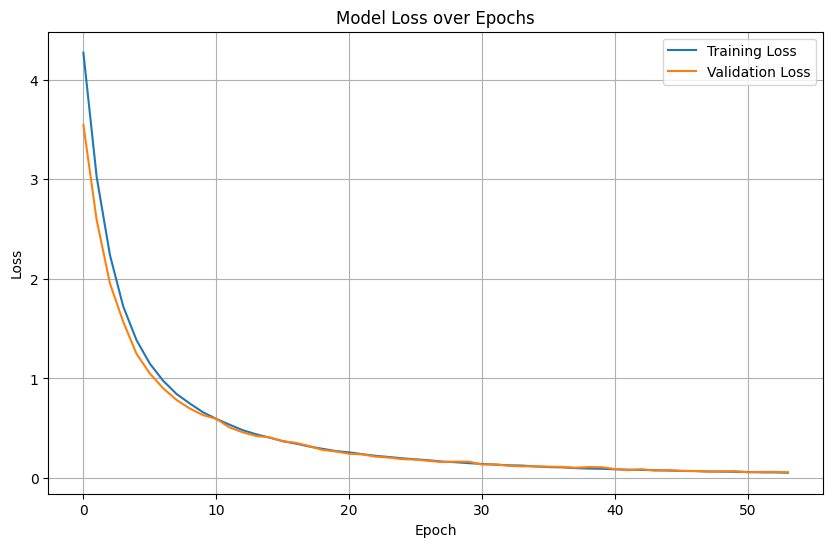

In [64]:
def plot_loss(history):
    """
    Plots the training and validation loss over epochs.

    Parameters:
    history (keras.callbacks.History): The history object returned from model.fit().
    """
    plt.figure(figsize=(10, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.grid(True)
    plt.show()

# Example usage:
plot_loss(history)

In [65]:
y_pred = trained_model.predict(X_test)
scaled_y_pred = inverse_scale(scalar,y_pred)
scaled_y_test = inverse_scale(scalar,y_test)
# Flatten the y_test and y_pred arrays (in case they are multi-dimensional)
y_test = scaled_y_test.flatten()
y_pred = scaled_y_pred.flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step


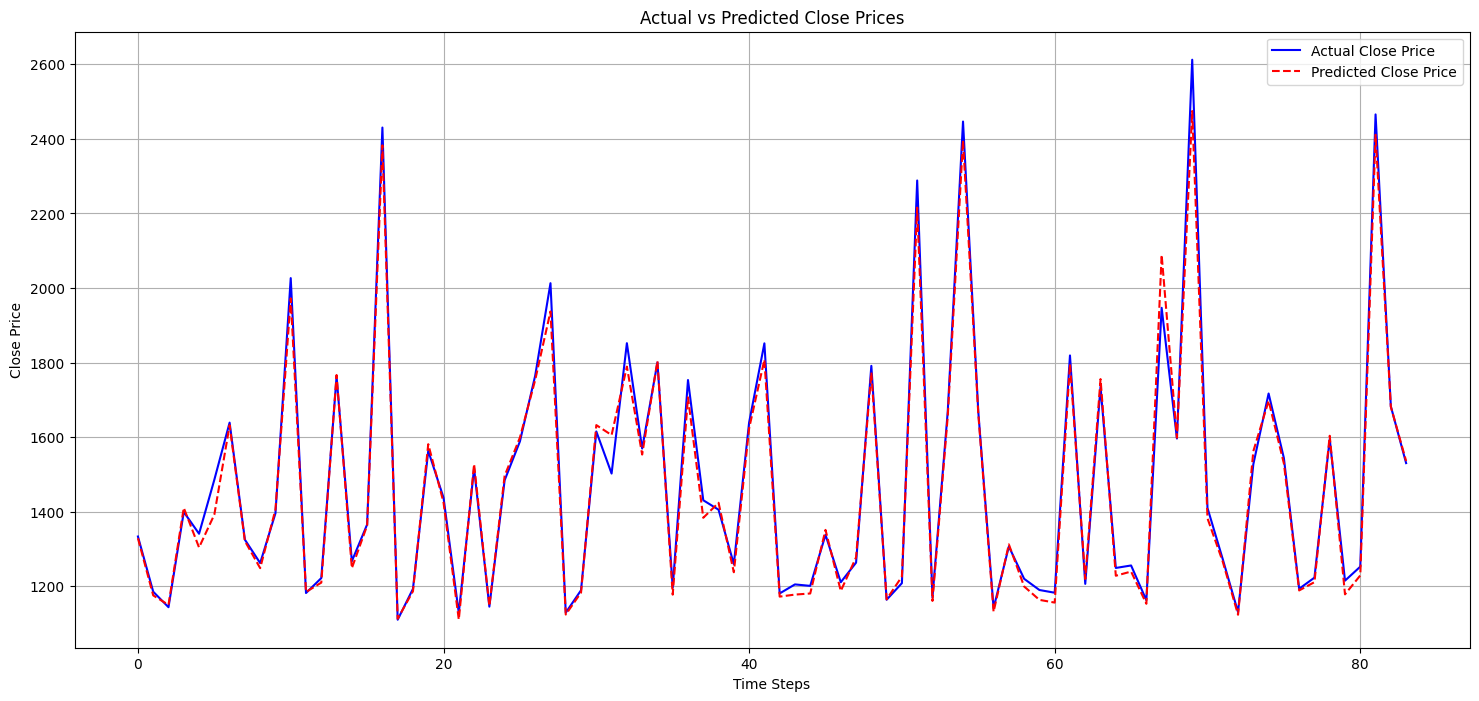

In [66]:
# Plot the actual close prices vs predicted close prices
plt.figure(figsize=(18, 8))
plt.plot(y_test, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='red', linestyle='--')

plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

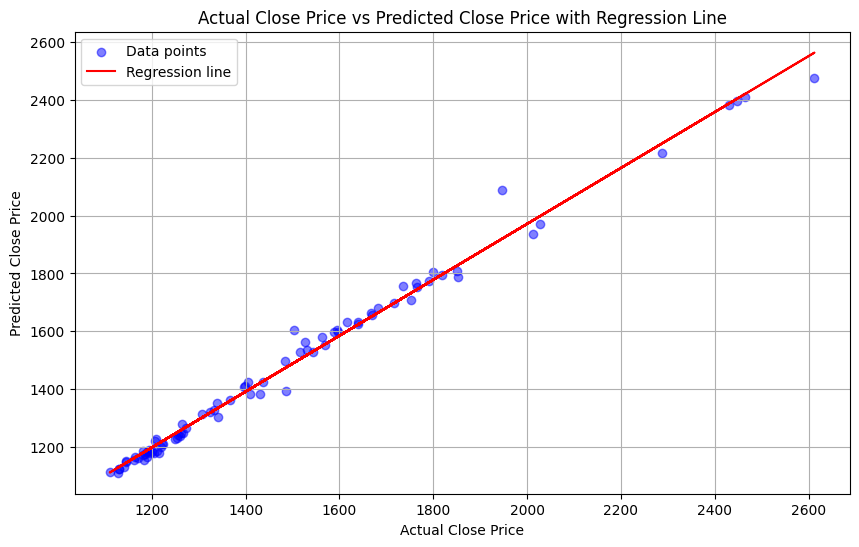

In [67]:
# Calculate the line of best fit (linear regression)
m, b = np.polyfit(y_test, y_pred, 1)

# Create scatter plot and regression line
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Data points')
plt.plot(y_test, m*y_test + b, color='red', label='Regression line')
plt.title('Actual Close Price vs Predicted Close Price with Regression Line')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
def calculate_r2_score(y_true, y_pred):
        """
        Calculate the R² score.

        Parameters:
        y_true (numpy.ndarray): True values.
        y_pred (numpy.ndarray): Predicted values.

        Returns:
        float: R² score.
        """
        return r2_score(y_true, y_pred)

calculate_r2_score(y_test, y_pred)

0.988983748613126

# This is for Paper Presentation

In [55]:
S_data, _ = scale_data(data)
P_test_X, P_test_y=look_back_window(S_data, 'Close', 3)


In [56]:
y_pred = trained_model.predict(P_test_X[200:400])
scaled_y_pred = inverse_scale(scalar,y_pred)
scaled_y_test = inverse_scale(scalar,P_test_y[200:400])
y_test = scaled_y_test.flatten()
y_pred = scaled_y_pred.flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


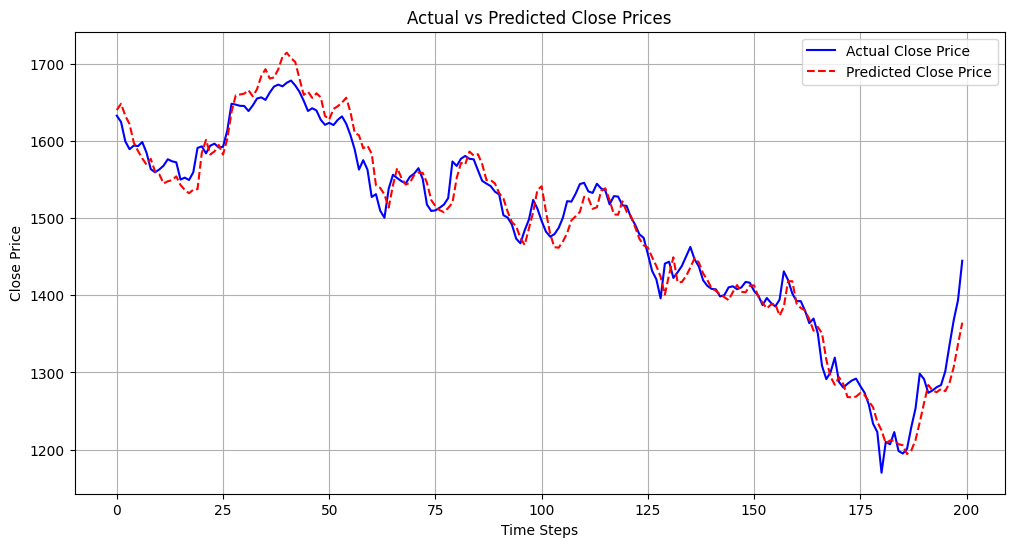

In [57]:
# Plot the actual close prices vs predicted close prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='red', linestyle='--')

plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()